# Extract Features

In [1]:
#imports
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import re

import nltk
from nltk.corpus import stopwords

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1020)>


In [2]:
import re

#load previously saved artifacts
tfidf = joblib.load("../artifacts/no_punctuation_no_stop_words/tfidf_vectorizer.joblib")

#load data (same splits used earlier)
train_csv = "../data/train.csv"

train = pd.read_csv(train_csv)

# preprocess (same method applied earlier)
# cleaning the dataset - lowercases and removes extra whitespaces and special chars in every text
def clean_data(text):
    #check for actual missing values
    if pd.isna(text) or text is None:
        return None
        
    #convert to string and strip whitespace
    text_str = str(text).strip()
    
    #check for literal string "None", "nan", or empty
    if text_str.lower() in ['none', 'nan', 'null', '']:
        return None
    
    #standard cleaning (lowercase + remove special chars)
    text_str = text_str.lower()
    clean_text = re.sub(r'[^\w\s]|_', '', text_str)
    
    #check if the result is empty (e.g., text was just punctuation)
    if not clean_text.strip():
        return None
        
    return clean_text

train['text_clean'] = train['Text'].apply(clean_data)
train = train.dropna(subset=['text_clean']).reset_index(drop=True)

X_train = tfidf.transform(train['text_clean'])

# Calculate the number of non-zero elements for each row
non_zero_counts = X_train.getnnz(axis=1)

# Identify rows that have at least one valid word
valid_indices = non_zero_counts > 0

# Filter both the Matrix and the DataFrame
X_train = X_train[valid_indices]
train = train[valid_indices].reset_index(drop=True)

print(f"Rows dropped due to empty vectors: {len(valid_indices) - sum(valid_indices)}")
print(f"Final Shape for Clustering: {X_train.shape}")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ate', 'eramos', 'estao', 'estavamos', 'estiveramos', 'estivessemos', 'foramos', 'fossemos', 'ha', 'hao', 'houveramos', 'houverao', 'houveriamos', 'houvessemos', 'ja', 'nao', 'sao', 'sera', 'serao', 'seriamos', 'so', 'tambem', 'tera', 'terao', 'teriamos', 'tinhamos', 'tiveramos', 'tivessemos', 'voce', 'voces'] not in stop_words.
  warnings.warn(


Rows dropped due to empty vectors: 7
Final Shape for Clustering: (50547, 5000)


# a) Apply K-Means with K=5 on your training set.

In [3]:
from sklearn.cluster import KMeans


# Initialize K-Means
kmeans = KMeans(
    n_clusters=5,
    init='k-means++',
    n_init=10,
    random_state=42,
    algorithm = "lloyd",
)

# Fit the model on the training set
print("Fitting K-Means with K=5 on X_train...")
kmeans.fit(X_train)

# Get the cluster assignments
train_cluster_labels = kmeans.labels_

print("K-Means training complete.")
print(f"Cluster labels shape: {train_cluster_labels.shape}")

# Save the model for use in 3b and 3c
joblib.dump(kmeans, "../artifacts/no_punctuation_no_stop_words/models/kmeans_model.joblib")

Fitting K-Means with K=5 on X_train...
K-Means training complete.
Cluster labels shape: (50547,)


['../artifacts/no_punctuation_no_stop_words/models/kmeans_model.joblib']

# b) Inspect 3 documents closest to each centroid, and afterwards, assign semantic labels to each cluster (e.g., “political fake news”, “health misinformation”).

In [4]:
dist_matrix = kmeans.transform(X_train)

# Iterate through each cluster to find nearest docs and top terms
print("--- Cluster Inspection ---")

feature_names = np.array(tfidf.get_feature_names_out())

for cluster_id in range(5):
    print(f"\n### CLUSTER {cluster_id} ###")
    
    # A. Print Top Keywords (Crucial for labeling!)
    # We find the center of the cluster and get the indices of the highest values
    centroid = kmeans.cluster_centers_[cluster_id]
    # Sort indices by value descending
    top_term_indices = centroid.argsort()[::-1][:10] 
    top_terms = feature_names[top_term_indices]
    print(f"Key Terms: {', '.join(top_terms)}")
    
    print("-" * 40)
    
    # B. Print Closest Documents
    closest_doc_indices = dist_matrix[:, cluster_id].argsort()[:3]

    for idx in closest_doc_indices:
        original_text = train.iloc[idx]['Text']
        label = train.iloc[idx]['Label']
        
        # Print a snippet (first 300 chars) to keep output readable
        print(f"  - [Row {idx}] (Label: {label}): {original_text[:300]}...")

--- Cluster Inspection ---

### CLUSTER 0 ###
Key Terms: nao, anos, sao, vida, pessoas, mae, porque, ter, ha, casa
----------------------------------------
  - [Row 30216] (Label: 0): CONHECE "O gajo que lhes atira mais às trombas" Anda nisto, a viagem da vida, há nove décadas - este domingo é dia de aniversário. "Não gosto nada de ter 90 anos." É a máxima queixa física que se lhe ouve. Pergunto-lhe se não está a ficar pessimista com o estado do país, ele que sempre foi um otimis...
  - [Row 44812] (Label: 0): “Estado não vai ter dinheiro para pagar reformas daqui a 15 anos” Para o economista vai haver um grave problema social quando os jovens tiverem de sustentar um exército de população envelhecida
Para João Duque, daqui a 15 anos vamos assistir a um grave problema social quando os jovens tiverem de sus...
  - [Row 3939] (Label: 0): Estado não vai ter dinheiro para pagar reformas daqui a 15 anos

 
O alerta é lançado por um economista, e apresenta dados! Daqui a 15 anos vamos assisti

# c) Visualize clusters in 2D using PCA. Create two plots: one colored by cluster assignment, one by true label.

Starting dimensionality reduction...
Reduction complete. New shape: (50547, 2)


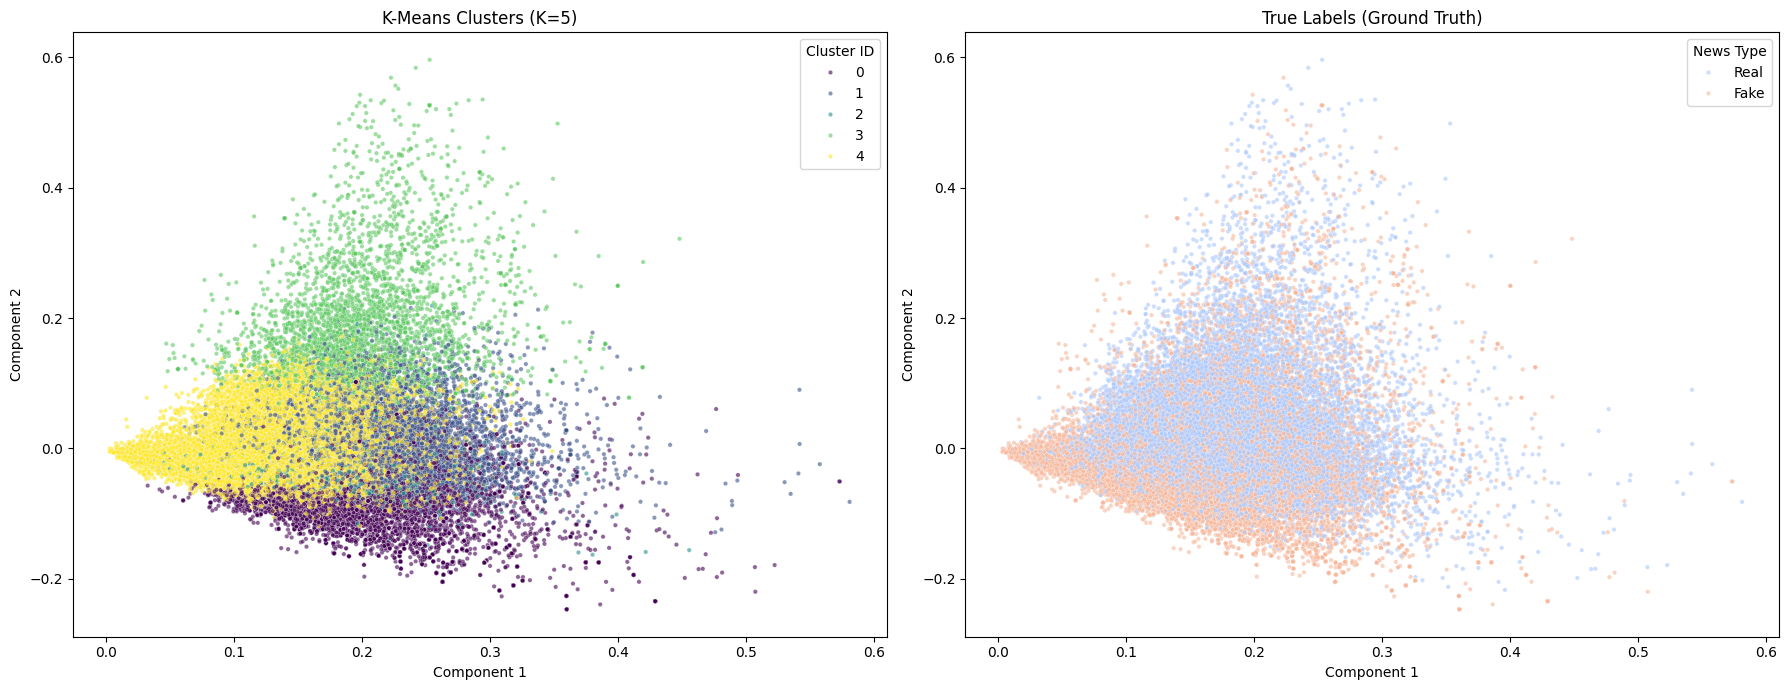

In [5]:
# --- 3c) Visualize clusters in 2D using PCA ---

from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns

print("Starting dimensionality reduction...")

# 1. Reduce dimensions to 2D
# Note: We use TruncatedSVD because standard PCA does not support sparse inputs 
# without converting to dense (which crashes memory on large text datasets).
pca_reducer = TruncatedSVD(n_components=2, random_state=42)
X_2d = pca_reducer.fit_transform(X_train)

print(f"Reduction complete. New shape: {X_2d.shape}")

# 2. Prepare Data for Plotting
# We create a temporary DataFrame to make plotting with Seaborn easier
plot_df = pd.DataFrame(X_2d, columns=['Component 1', 'Component 2'])
plot_df['Cluster'] = train_cluster_labels
# Map labels for better legend readability (0=Fake, 1=Real)
plot_df['True Label'] = train['Label'].map({0: 'Fake', 1: 'Real'})

# 3. Create the Side-by-Side Plots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- Plot 1: Colored by Cluster Assignment ---
sns.scatterplot(
    data=plot_df, 
    x='Component 1', 
    y='Component 2', 
    hue='Cluster', 
    palette='viridis', 
    s=10,             # Marker size
    alpha=0.6,        # Transparency
    ax=axes[0]
)
axes[0].set_title('K-Means Clusters (K=5)')
axes[0].legend(title='Cluster ID')

# --- Plot 2: Colored by True Label ---
sns.scatterplot(
    data=plot_df, 
    x='Component 1', 
    y='Component 2', 
    hue='True Label', 
    palette='coolwarm', # Red for Fake (warm), Blue for Real (cool) usually
    s=10, 
    alpha=0.6,
    ax=axes[1]
)
axes[1].set_title('True Labels (Ground Truth)')
axes[1].legend(title='News Type')

plt.tight_layout()
plt.show()